Imports of pandas, seaborn

In [1]:
import pandas as pd
import seaborn as sns
from itertools import islice
import nltk
from nameparser.parser import HumanName
import time
import csv

Download necessary ressources

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anwender\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Anwender\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Anwender\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Anwender\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

Read train dataset from csv file

In [3]:
df = pd.read_csv("../data/train.csv")

Statistical analysis about length of every "text" in dataset - For loop + Sorting by longest articles

Generate graph of average length of articles in 100 of characters

[Text(0.5, 0, '100 of characters'),
 Text(0, 0.5, 'Number of articles'),
 Text(0.5, 1.0, 'Length of articles in 100 of characters')]

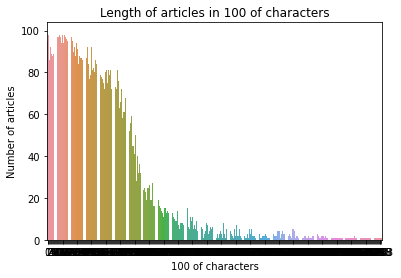

In [4]:
content_length = {}
for content in df["text"]:
    try:
        if len(content) in content_length:
            content_length[len(content)]+=1
        else:
            content_length[len(content)] = 1
    except: # Error in the dataset, one of the entries seems to be a float. To prevent execution stop: try/except.
        pass

content_length = dict(reversed(sorted(content_length.items(), key=lambda item: item[0]))) 

values = {}

for loop in content_length.items():
    if loop[0]//100 in values:
        values[loop[0]//100]+=1
    else:
        values[loop[0]//100] = 1

my_df = pd.DataFrame(values.items())
ax = sns.barplot(x=0, y=1, data=my_df)
ax.set(xlabel = '100 of characters', ylabel='Number of articles', title='Length of articles in 100 of characters')


Statistical analysis about length of every fake news (label = 1) in dataset - For loop + Sorting by longest articles

Generate graph of average length of articles in 100 of characters

[Text(0.5, 0, '100 of characters'),
 Text(0, 0.5, 'Number of articles'),
 Text(0.5, 1.0, 'Length of fake news in 100 of characters')]

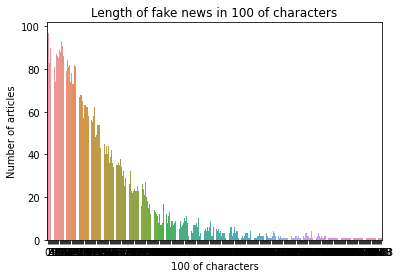

In [5]:
content_length = {}
for content in df.loc[df['label'] == 1]["text"]:
    try:
        if len(content) in content_length:
            content_length[len(content)]+=1
        else:
            content_length[len(content)] = 1
    except: # Error in the dataset, one of the entries seems to be a float. To prevent execution stop: try/except.
        pass

content_length = dict(reversed(sorted(content_length.items(), key=lambda item: item[0]))) 

values = {}

for loop in content_length.items():
    if loop[0]//100 in values:
        values[loop[0]//100]+=1
    else:
        values[loop[0]//100] = 1

my_df = pd.DataFrame(values.items())
ax = sns.barplot(x=0, y=1, data=my_df)
ax.set(xlabel = '100 of characters', ylabel='Number of articles', title='Length of fake news in 100 of characters')


Statistical analysis about length of every non fake news (label = 0) in dataset - For loop + Sorting by longest articles

Generate graph of average length of articles in 100 of characters

[Text(0.5, 0, '100 of characters'),
 Text(0, 0.5, 'Number of articles'),
 Text(0.5, 1.0, 'Length of non fake news in 100 of characters')]

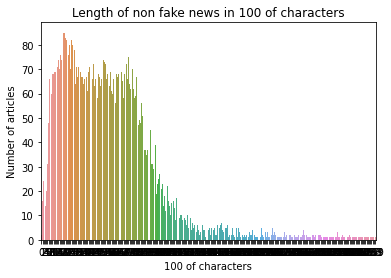

In [6]:
content_length = {}
for content in df.loc[df['label'] == 0]["text"]:
    try:
        if len(content) in content_length:
            content_length[len(content)]+=1
        else:
            content_length[len(content)] = 1
    except: # Error in the dataset, one of the entries seems to be a float. To prevent execution stop: try/except.
        pass

content_length = dict(reversed(sorted(content_length.items(), key=lambda item: item[0]))) 

values = {}

for loop in content_length.items():
    if loop[0]//100 in values:
        values[loop[0]//100]+=1
    else:
        values[loop[0]//100] = 1

my_df = pd.DataFrame(values.items())
ax = sns.barplot(x=0, y=1, data=my_df)
ax.set(xlabel = '100 of characters', ylabel='Number of articles', title='Length of non fake news in 100 of characters')

Check amount of names and save result to CSV file.

In [ ]:
def get_human_names(text):
    tokens = nltk.tokenize.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    sentt = nltk.ne_chunk(pos, binary = False)
    person_list = []
    person = []
    name = ""
    for subtree in sentt.subtrees(filter=lambda t: t.label() == 'PERSON'):
        for leaf in subtree.leaves():
            person.append(leaf[0])
        if len(person) > 1: #avoid grabbing lone surnames
            for part in person:
                name += part + ' '
            if name[:-1] not in person_list:
                person_list.append(name[:-1])
            name = ''
        person = []

    return (person_list)

start_time = time.time()

f = open("../data/name_output.csv", 'w', encoding='UTF8', newline='')
writer = csv.writer(f)
writer.writerow(["article_id","nb_names"])

for id, content in enumerate(df["text"]):
    if id%100==0:
        print(id)
    try:
        writer.writerow([id, len(get_human_names(content))])
    except:
        pass

print(time.time()-start_time)
f.close()


Separate number of proper names depending on fake/ non-fake news.
Process CSV file.

In [7]:
df_names = pd.read_csv("../data/name_output.csv")

non_fake = {}
fake = {}

non_fake_sum = 0
fake_sum = 0

total_non_fake = 0
total_fake = 0

for index, row in df_names.iterrows():
    
    if df.loc[df["id"] == row["article_id"], "label"].to_string(index=False) == "1":

        if row["nb_names"] in fake:
            fake[row["nb_names"]]+=1
        else:
            fake[row["nb_names"]] = 1
        fake_sum += row["nb_names"]
        total_fake+=1

    else:
        if row["nb_names"] in non_fake:
            non_fake[row["nb_names"]]+=1
        else:
            non_fake[row["nb_names"]] = 1
        
        non_fake_sum += row["nb_names"]
        total_non_fake+=1

print(f"Non fake news amount: {total_non_fake}  -  Added up number of proper names: {non_fake_sum}  -  Average: {non_fake_sum/total_non_fake}")
print(f"Fake news amount: {total_fake}  -  Added up number of proper names: {fake_sum}  -  Average: {fake_sum/total_fake}")
print(f"All news amount: {total_fake+total_non_fake}  -  Added up number of all proper names: {fake_sum+non_fake_sum}  -  Average: {(fake_sum+non_fake_sum)/(total_fake+total_non_fake)}")


Non fake news amount: 10387  -  Added up number of proper names: 109438  -  Average: 10.53605468373929
Fake news amount: 10374  -  Added up number of proper names: 64132  -  Average: 6.18199344515134
All news amount: 20761  -  Added up number of all proper names: 173570  -  Average: 8.36038726458263


Generate graph for fake news.

[Text(0.5, 0, 'Number of proper names'),
 Text(0, 0.5, 'Amount of articles'),
 Text(0.5, 1.0, 'Fake news graph')]

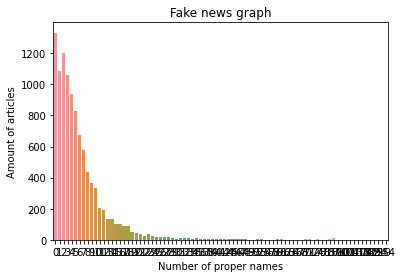

In [8]:
fake_news_df = pd.DataFrame(fake.items())
ax = sns.barplot(x=0, y=1, data=fake_news_df)
ax.set(xlabel = 'Number of proper names', ylabel='Amount of articles', title='Fake news graph')

Generate graph for non fake news.

[Text(0.5, 0, 'Number of proper names'),
 Text(0, 0.5, 'Amount of articles'),
 Text(0.5, 1.0, 'Non Fake news graph')]

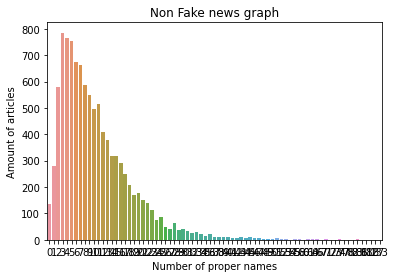

In [9]:
non_fake_news_df = pd.DataFrame(non_fake.items())
ay = sns.barplot(x=0, y=1, data=non_fake_news_df)
ay.set(xlabel = 'Number of proper names', ylabel='Amount of articles', title='Non Fake news graph')